https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

TODO:

- write some description or note
- add exercise

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Stationarity

In [8]:
airpassengers = pd.read_csv('../datasets/AirPassengers.csv')

airpassengers_series = pd.Series(airpassengers['#Passengers'].values, 
                            index = pd.date_range('1949-01', periods = len(airpassengers), freq='M'))

C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'airpassengers')

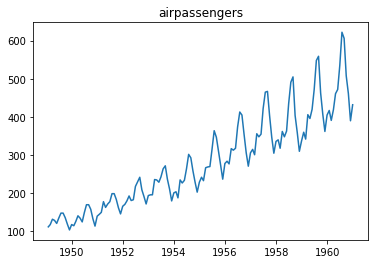

In [9]:
plt.plot(airpassengers_series)
plt.title('airpassengers')

There are many techniques (logarithm, exponential, de-trending, differencing) can be use to transform non-stationary series into stationary.

Which technique to use depend on the pattern of our time series

Since we has a series with increment variance, logarithm transformation can be use to smooth out the variance.

In [10]:
airpassengers_log = np.log(airpassengers_series)

Text(0.5, 1.0, 'log transformation')

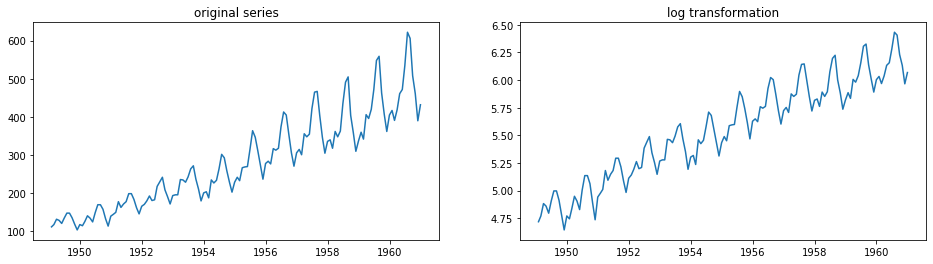

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_series)
ax1.set_title('original series')

ax2.plot(airpassengers_log)
ax2.set_title('log transformation')

differencing

In [12]:
airpassengers_diff = airpassengers_log.diff()

Text(0.5, 1.0, 'differencing')

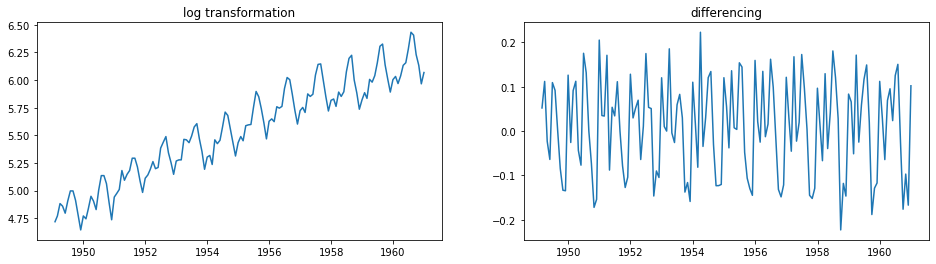

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_log)
ax1.set_title('log transformation')

ax2.plot(airpassengers_diff)
ax2.set_title('differencing')

## Stationarity Check

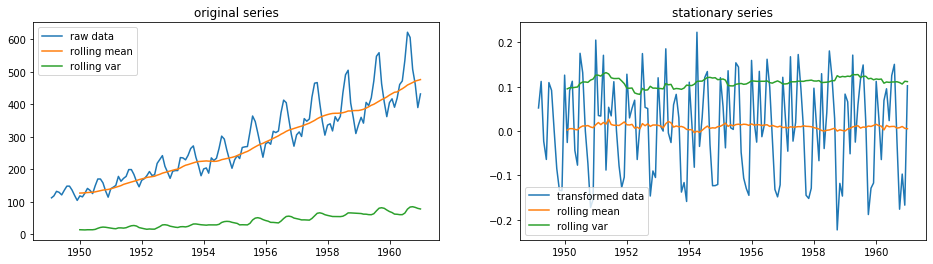

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_series, label = 'raw data')
ax1.plot(airpassengers_series.rolling(window=12).mean(), label="rolling mean");
ax1.plot(airpassengers_series.rolling(window=12).std(), label="rolling var");
ax1.set_title('original series')
ax1.legend()

ax2.plot(airpassengers_diff, label = 'transformed data')
ax2.plot(airpassengers_diff.rolling(window=12).mean(), label="rolling mean");
ax2.plot(airpassengers_diff.rolling(window=12).std(), label="rolling var");
ax2.set_title('stationary series')
ax2.legend()

### Augmented Dickey-Fuller Test (ADF)

ADF is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.

A time series is stationary if a single shift in time doesn’t change the time series statistical properties, in which case unit root does not exist.

The Null and Alternate hypothesis of the Augmented Dickey-Fuller test is defined as follows:
- Null Hypothesis states there is the presence of a unit root.
- Alternate Hypothesis states there is no unit root. In other words, Stationarity exists.

https://machinelearningmastery.com/time-series-data-stationary-python/

http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/

In [15]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)

In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(airpassengers_series, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        1.564685
P-Value                   0.997748
# Lags Used              12.000000
# Observations Used     131.000000
Critical Value (1%)      -3.481282
Critical Value (5%)      -2.883868
Critical Value (10%)     -2.578677
dtype: float64


In [17]:
result = adfuller(airpassengers_diff[1:], maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.053032
P-Value                   0.030230
# Lags Used              12.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


### Test Stationary using Autocorrelation Function (ACF)

http://rstudio-pubs-static.s3.amazonaws.com/311446_08b00d63cc794e158b1f4763eb70d43a.html

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.graphics.gofplots import qqplot
# from scipy.stats import probplot

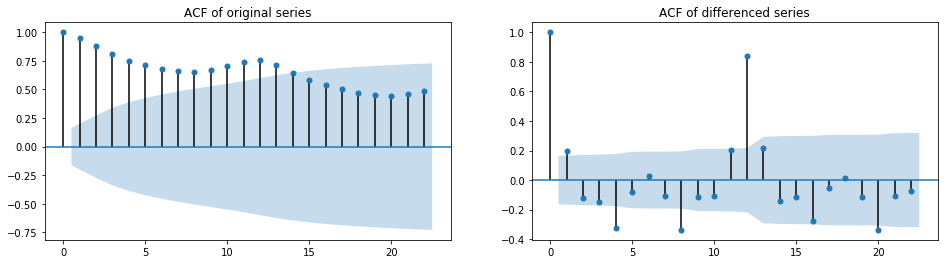

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

plot_acf(airpassengers_series, ax1)
ax1.set_title('ACF of original series')

plot_acf(airpassengers_diff[1:], ax2)
ax2.set_title('ACF of differenced series')

plt.show()

# Simple Forecasting

In [20]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

airpassengers_train = airpassengers_series[:-24]
airpassengers_test = airpassengers_series[-24:]

airpassengers_log_train = airpassengers_log[:-24]
airpassengers_log_test = airpassengers_log[-24:]

airpassengers_diff_train = airpassengers_diff[:-24]
airpassengers_diff_test = airpassengers_diff[-24:]

ses = SimpleExpSmoothing(airpassengers_diff_train[1:])
ses = ses.fit()

ses_forecast = ses.forecast(24)

C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


Text(0.5, 1.0, 'forecast for next 24 month')

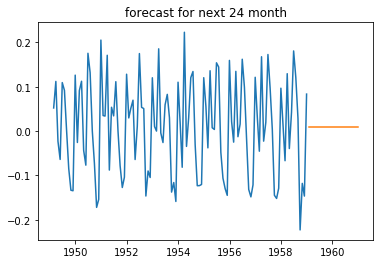

In [21]:
plt.plot(airpassengers_diff_train)
plt.plot(ses_forecast)
plt.title('forecast for next 24 month')

Inverse differencing

In [22]:
ses_forecast[0] = ses_forecast[0] + airpassengers_log_train[-1]
ses_forecast_inv_diff = ses_forecast.cumsum()

Inverse log transformation

In [23]:
ses_forecast_inv_log = np.exp(ses_forecast_inv_diff)

Text(0.5, 1.0, 'inverse log transformation')

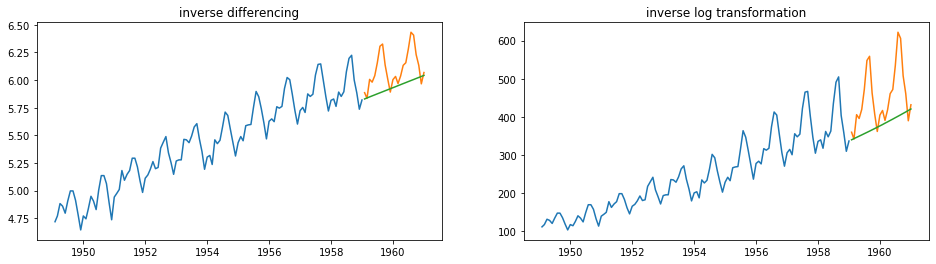

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_log_train)
ax1.plot(airpassengers_log_test)
ax1.plot(ses_forecast_inv_diff)
ax1.set_title('inverse differencing')

ax2.plot(airpassengers_train)
ax2.plot(airpassengers_test)
ax2.plot(ses_forecast_inv_log)
ax2.set_title('inverse log transformation')

# ARIMA

ARIMA is stand for Autoregressive Integrated Moving Average. The integrated refers to differencing hence it allow the model to support series with trend.

ARIMA expects data that is either not seasonal or has the seasonal component removed, thus we can perform seasonal differencing to eliminate the seasonality in the data.

In [25]:
from statsmodels.tsa.arima_model import ARIMA

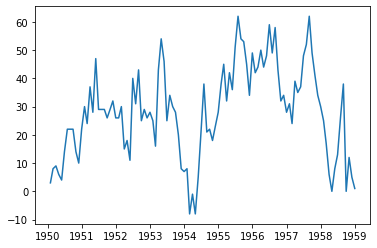

In [26]:
airpassengers_season_diff_train = airpassengers_train.diff(12)

plt.plot(airpassengers_season_diff_train)

In [27]:
arima = ARIMA(airpassengers_season_diff_train.dropna(), order=(4,0,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(4, 1)   Log Likelihood                -399.378
Method:                       css-mle   S.D. of innovations              9.715
Date:                Wed, 15 Apr 2020   AIC                            812.756
Time:                        14:59:41   BIC                            831.531
Sample:                    01-31-1950   HQIC                           820.368
                         - 12-31-1958                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.6614      5.614      4.571      0.000      14.658      36.665
ar.L1.y        1.0792      0.684      1.579      0.114      -0.261       2.419
ar.L2.y       -0.0444      0.489     -0.091      0.928      -1.003       0.915
ar.L3.y       -0.2515      0.199     -1.262      0.207      -0.642       0.139
ar.L4.y        0.1140      0.113      1.007      0.314      -0.108       0.336
ma.L1.y       -0.3756      0.684     -0.549      0.583      -1.717       0.966
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9002           -0.0000j            1.9002           -0.5000
AR.2            1.1511           -0.0000j            1.1511           -0.0000
AR.3            1.4776           -1.3520j            2.0028           -0.1179
AR.4            1.4776           +1.3520j            2.0028            0.1179
MA.1            2.6621           +0.0000j            2.6621            0.0000
-----------------------------------------------------------------------------
"""

The values under *coef* are the weights of the respective terms. 

AIC and BIC is to tell how good is the model and can be use to compare with other models. The lower the AIC the better the model



## Residuals

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:
- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
- The residuals have constant variance.
- The residuals are normally distributed.


Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

In [28]:
residuals = pd.Series(arima.resid)

In [29]:
import seaborn as sns

def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()

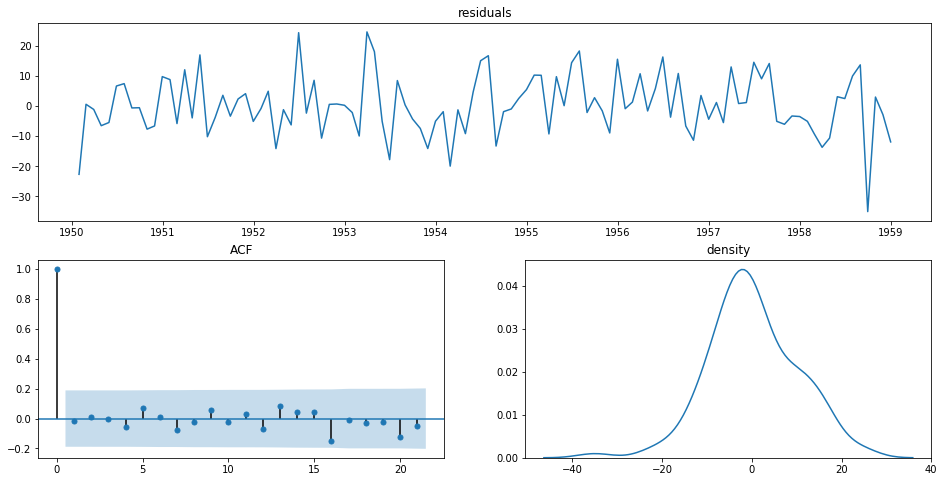

In [30]:
check_residuals(residuals)

In [31]:
arima_forecast, se, conf = arima.forecast(24)

arima_forecast = pd.Series(arima_forecast, index=airpassengers_test.index)
lower_series = pd.Series(conf[:, 0], index=airpassengers_test.index)
upper_series = pd.Series(conf[:, 1], index=airpassengers_test.index)

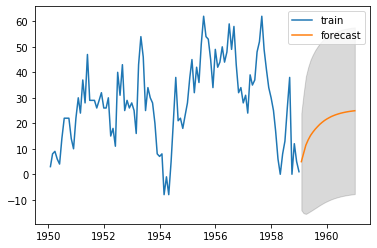

In [32]:
plt.plot(airpassengers_season_diff_train, label='train')
plt.plot(arima_forecast, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.legend()

In [33]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

def inverse_differencing_forecast(orig_series, diff_series, forecast_series, interval):
    series_merge = diff_series.append(forecast_series)
    inverse_diff_series = pd.Series(inverse_differencing(orig_series, series_merge, interval), 
                                    index=series_merge.index)
    return inverse_diff_series[-len(forecast_series):]

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

In [34]:
# inverse differenced series back to original series
airpassengers_forecast_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, arima_forecast, 12)
airpassengers_lower_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, lower_series, 12)
airpassengers_upper_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, upper_series, 12)

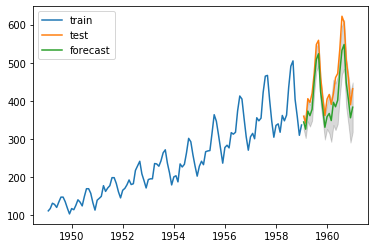

In [35]:
train_test_forecast_plot(airpassengers_train, airpassengers_test, airpassengers_forecast_series, 
                         [airpassengers_lower_series, airpassengers_upper_series])

In [36]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(airpassengers_test, airpassengers_forecast_series)
print('Test MSE: ', mse)

Test MSE:  2240.830411243067


# SARIMA

Seasonal Autoregressive Integrated Moving Average (SARIMA) ia a method to forecast univariate time series with trend and seasonality.

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
sarimax = SARIMAX(airpassengers_train, order=(3,1,1), seasonal_order=(0,1,0,12)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                -397.385
Date:                             Wed, 15 Apr 2020   AIC                            804.771
Time:                                     14:59:45   BIC                            818.135
Sample:                                 01-31-1949   HQIC                           810.188
                                      - 12-31-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5364      0.202      2.651      0.008       0.140       0.933
ar.L2          0.1857      0.145      1.277      0.202      -0.099       0.471
ar.L3         -0.1562      0.145     -1.074      0.283      -0.441       0.129
ma.L1         -0.7948      0.234     -3.400      0.001      -1.253      -0.337
sigma2        98.2491     13.823      7.107      0.000      71.156     125.342
===================================================================================
Ljung-Box (Q):                       35.87   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.66   Prob(JB):                         0.28
Heteroskedasticity (H):               1.53   Skew:                            -0.09
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

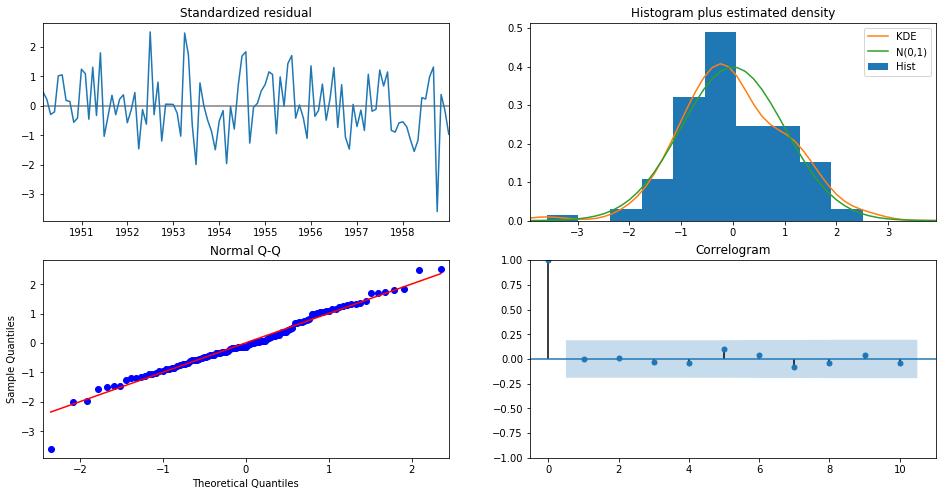

In [39]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [40]:
sarimax_forecast = sarimax.get_forecast(24)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

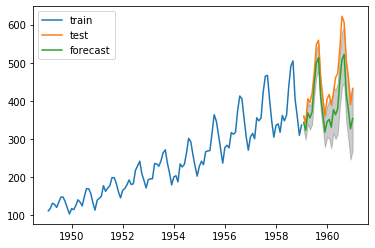

In [41]:
plt.plot(airpassengers_train, label='train')
plt.plot(airpassengers_test, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,
                 sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)

plt.legend()


# Grid Search

Grid search is the process of performing exhaustive searching throught a manually specified parameters in order to determine the optimal values for a given model.

For example, ARIMA has the parameters p, d, and q. we can manually specify range of values for parameters p, d, q, and build models based on the all the combination of parameters in p, d, and q. The measurement for the models can be in-sample error (AIC, BIC), or out-sample error (MSE). Finally, the model with the lowest error will be selected.

In [42]:
param_p = [0,1,2,3,4,5]
param_d = [0,1] # ARIMA only support two times of differencing
param_q = [0,1,2]

In [43]:
best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            try:
                arima = ARIMA(airpassengers_season_diff_train.dropna(), order=(p,d,q)).fit()
                if best_error is None or arima.aic < best_error:
                    best_error = arima.aic
                    best_params = (p,d,q)
                    best_model = arima
                print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
            except:
                pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))

ARIMA(0,0,0), AIC=910.2364820860948
ARIMA(0,0,1), AIC=859.1128781864566
ARIMA(0,0,2), AIC=828.5246316416875
ARIMA(0,1,0), AIC=809.6542460236442
ARIMA(0,1,1), AIC=805.6496003606285
ARIMA(0,1,2), AIC=807.6283595010948
ARIMA(1,0,0), AIC=809.393746578306
ARIMA(1,0,1), AIC=809.4263830454809
ARIMA(1,0,2), AIC=809.5605918479613
ARIMA(1,1,0), AIC=805.2809094674456
ARIMA(1,1,1), AIC=806.8126968994836
ARIMA(2,0,0), AIC=808.8406195222619
ARIMA(2,0,1), AIC=809.6502710767701
ARIMA(2,0,2), AIC=810.8559426312364
ARIMA(2,1,0), AIC=807.0927383370299
ARIMA(2,1,1), AIC=808.7922440794973
ARIMA(2,1,2), AIC=806.1953589118502
ARIMA(3,0,0), AIC=809.3561451224032
ARIMA(3,0,1), AIC=811.2314792084383
ARIMA(3,0,2), AIC=810.6915702861313
ARIMA(3,1,0), AIC=807.0752100440789
ARIMA(3,1,1), AIC=806.7712857661666
ARIMA(3,1,2), AIC=806.0101766447488
ARIMA(4,0,0), AIC=811.0125054430393
ARIMA(4,0,1), AIC=812.7557392583917
ARIMA(4,0,2), AIC=809.3569003847958
ARIMA(4,1,0), AIC=806.5985563765503
ARIMA(4,1,1), AIC=808.5663811

C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


ARIMA(5,0,2), AIC=811.2139174997081
ARIMA(5,1,0), AIC=808.5539394303842
ARIMA(5,1,1), AIC=808.3691059422574
ARIMA(5,1,2), AIC=810.214862153583
Best Error=805.2809094674456, Best Params=(1, 1, 0)


In [44]:
arima_forecast, se, conf = best_model.forecast(24)

arima_forecast = pd.Series(arima_forecast, index=airpassengers_test.index)
lower_series = pd.Series(conf[:, 0], index=airpassengers_test.index)
upper_series = pd.Series(conf[:, 1], index=airpassengers_test.index)

In [45]:
# inverse differenced series back to original series
airpassengers_forecast_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, arima_forecast, 12)
airpassengers_lower_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, lower_series, 12)
airpassengers_upper_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, upper_series, 12)

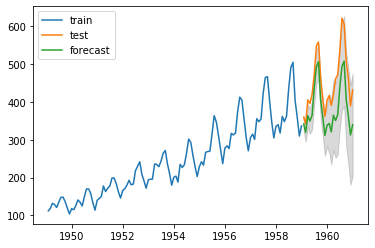

In [46]:
train_test_forecast_plot(airpassengers_train, airpassengers_test, airpassengers_forecast_series, 
                         [airpassengers_lower_series, airpassengers_upper_series])

In [47]:
mse = mean_squared_error(airpassengers_test, airpassengers_forecast_series)
print('Test MSE: ', mse)

Test MSE:  5569.355926908726


# Auto Arima

Pyramid brings R’s beloved `auto.arima` to Python

In [62]:
import pmdarima as pm

auto_arima = pm.auto_arima(airpassengers_train, m=12,
                            trace=True, seasonal=True,
                            error_action='ignore',  
                            suppress_warnings=True)


Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(1, 1, 1, 12) (constant=True); AIC=813.746, BIC=835.203, Time=1.751 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=910.236, BIC=915.601, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=810.646, BIC=821.375, Time=0.389 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=860.575, BIC=871.304, Time=0.307 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=1060.479, BIC=1063.161, Time=0.009 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=809.411, BIC=817.458, Time=0.056 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 1, 12) (constant=True); AIC=810.721, BIC=821.449, Time=0.294 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 1, 12) (constant=True); AIC=812.509, BIC=825.920, Time=0.936 seconds
Fit ARIMA: (2, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=808.863, BIC=819.592, Time=0.083 seconds
Fit ARIMA: (2, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=810.482, BIC=823.892, Tim

In [73]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Wed, 15 Apr 2020   AIC                            808.863
Time:                                    15:07:40   BIC                            819.592
Sample:                                         0   HQIC                           813.213
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (Q):                       41.99   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.38   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
auto_arima_forecast = auto_arima.predict(n_periods=24)
auto_arima_forecast_series = pd.Series(auto_arima_forecast, index=airpassengers_test.index)

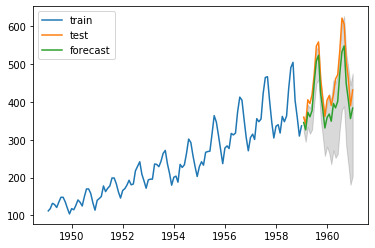

In [75]:
train_test_forecast_plot(airpassengers_train, airpassengers_test, auto_arima_forecast_series, 
                         [airpassengers_lower_series, airpassengers_upper_series])

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 